In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import shutil
from scipy.stats import iqr
import time
from sklearn.model_selection import train_test_split
from PIL import Image

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rc('font', family='serif')

# 1. 采集人脸数据

In [3]:
# 获取采集人名字
person_name = input("请输入要采集的人的名字：")

# 创建人脸检测器
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# 打开摄像头
cap = cv2.VideoCapture(0)

# 设置人脸图片计数器
face_count = 0

# 创建保存人脸图像的文件夹
save_dir = f'face_dataset/{person_name}'
os.makedirs(save_dir, exist_ok=True)

# 记录上次采集时间
last_capture_time = time.time()

while True:
    # 读取每一帧
    ret, frame = cap.read()
    if not ret:
        break

    # 将帧转换为灰度图像
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # 使用Viola-Jones算法检测人脸
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        # 在图像中绘制矩形框
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)

        # 判断是否达到采集时间间隔
        current_time = time.time()
        if current_time - last_capture_time >= 0.1:
            # 保存人脸图像
            face_roi = frame[y:y+h, x:x+w]
            cv2.imwrite(f'{save_dir}/face_{person_name}_{face_count}.jpg', face_roi)
            face_count += 1

            # 更新上次采集时间
            last_capture_time = current_time

    # 显示带有人脸矩形框的图像
    cv2.imshow('Face Detection', frame)

    # 按 'q' 键退出循环
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# 释放摄像头和关闭所有窗口
cap.release()
cv2.destroyAllWindows()

# 2.清洗人脸数据
## 2.1 读取收集的人脸数据

In [5]:
# 定义数据集目录
dataset_dir = 'face_dataset'

# 初始化一个字典来保存每个人的图像数量
face_counts = {}

# 初始化一个字典来保存每个人的图像尺寸
face_sizes = {}

# 遍历每个人的文件夹
for person_name in os.listdir(dataset_dir):
    person_dir = os.path.join(dataset_dir, person_name)
    if os.path.isdir(person_dir):
        # 统计每个人的图像数量
        num_faces = len([f for f in os.listdir(person_dir) if os.path.isfile(os.path.join(person_dir, f))])
        face_counts[person_name] = num_faces
        # 初始化一个列表来保存当前人的图像尺寸
        sizes = []
        file_paths = []

        for filename in os.listdir(person_dir):
            file_path = os.path.join(person_dir, filename)
            if os.path.isfile(file_path):
                # 读取图像
                image = cv2.imread(file_path)
                if image is not None:
                    # 获取图像尺寸（假设是1:1的长宽比）
                    height, width = image.shape[:2]
                    sizes.append(height)
                    file_paths.append(file_path)
        face_sizes[person_name] = (sizes, file_paths)

## 2.2 统计人脸数据

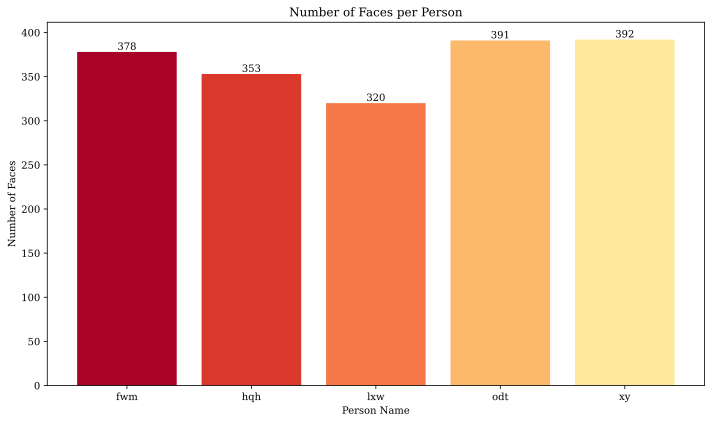

In [8]:
# 定义颜色列表（每个颜色为 RGB 格式）
colors = [
    (168/255, 3/255, 38/255),
    (218/255, 56/255, 42/255),
    (246/255, 121/255, 72/255),
    (253/255, 185/255, 107/255),
    (254/255, 233/255, 157/255),
    (244/255, 251/255, 211/255),
    (202/255, 232/255, 242/255),
    (146/255, 197/255, 222/255),
    (92/255, 144/255, 194/255),
    (57/255, 81/255, 162/255)
]

plt.figure(figsize=(10, 6))
bars = plt.bar(face_counts.keys(), face_counts.values(), color=colors[:len(face_counts)])

# 在柱顶标注数量
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.1, yval, ha='center', va='bottom')

plt.xlabel('Person Name')
plt.ylabel('Number of Faces')
plt.title('Number of Faces per Person')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 2.3 利用四分位法进行数据清洗

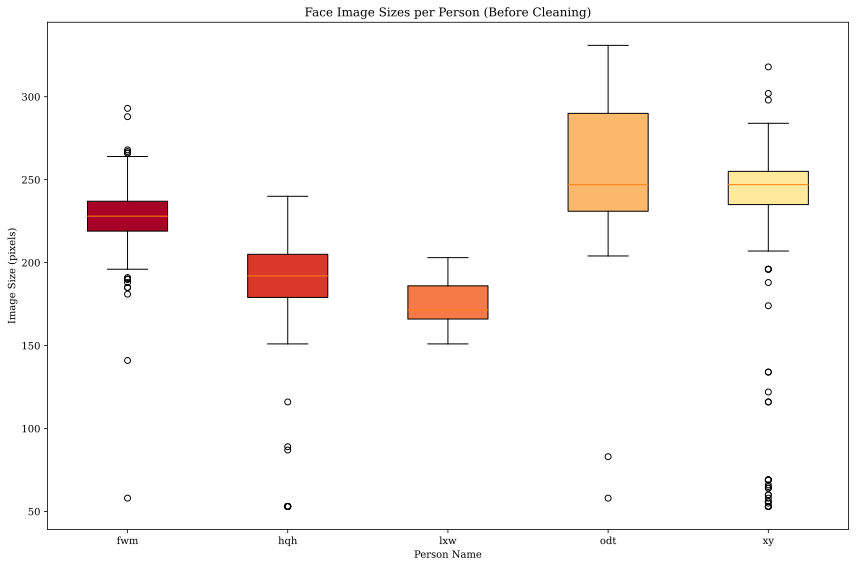

In [12]:
# 准备绘制箱线图的数据
data = [sizes for sizes, _ in face_sizes.values()]
labels = list(face_sizes.keys())

# 绘制清理前的箱线图
plt.figure(figsize=(12, 8))
box = plt.boxplot(data, labels=labels, patch_artist=True)

# 给每个箱线图框设置不同的颜色
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.xlabel('Person Name')
plt.ylabel('Image Size (pixels)')
plt.title('Face Image Sizes per Person (Before Cleaning)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("1.png",dpi=800)

In [15]:
filtered_dataset_dir = 'filtered_face_dataset'
filtered_face_sizes = {}

# 去除离群点
for person_name, (sizes, file_paths) in face_sizes.items():
    sizes = np.array(sizes)
    Q1 = np.percentile(sizes, 25)
    Q3 = np.percentile(sizes, 75)
    IQR = iqr(sizes)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # 创建过滤后人的目录
    filtered_person_dir = os.path.join(filtered_dataset_dir, person_name)
    if not os.path.exists(filtered_person_dir):
        os.makedirs(filtered_person_dir)

    # 筛选出非离群点的图像
    filtered_sizes = []
    filtered_file_paths = []
    for size, file_path in zip(sizes, file_paths):
        if lower_bound <= size <= upper_bound:
            filtered_sizes.append(size)
            filtered_file_paths.append(file_path)
            # 拷贝非离群点图像文件到过滤后的目录
            dest_path = os.path.join(filtered_person_dir, os.path.basename(file_path))
            shutil.copy2(file_path, dest_path)

            # 缩小图像大小为150x150
            with Image.open(dest_path) as img:
                img = img.resize((250, 250), Image.LANCZOS)
                img.save(dest_path)
        else:
            # 打印离群点图像文件路径
            print(f'Removing outlier image: {file_path}')
    
    filtered_face_sizes[person_name] = filtered_sizes

Removing outlier image: face_dataset\fwm\face_fwm_10.jpg
Removing outlier image: face_dataset\fwm\face_fwm_11.jpg
Removing outlier image: face_dataset\fwm\face_fwm_119.jpg
Removing outlier image: face_dataset\fwm\face_fwm_13.jpg
Removing outlier image: face_dataset\fwm\face_fwm_148.jpg
Removing outlier image: face_dataset\fwm\face_fwm_15.jpg
Removing outlier image: face_dataset\fwm\face_fwm_18.jpg
Removing outlier image: face_dataset\fwm\face_fwm_19.jpg
Removing outlier image: face_dataset\fwm\face_fwm_23.jpg
Removing outlier image: face_dataset\fwm\face_fwm_3.jpg
Removing outlier image: face_dataset\fwm\face_fwm_355.jpg
Removing outlier image: face_dataset\fwm\face_fwm_59.jpg
Removing outlier image: face_dataset\fwm\face_fwm_60.jpg
Removing outlier image: face_dataset\fwm\face_fwm_61.jpg
Removing outlier image: face_dataset\fwm\face_fwm_62.jpg
Removing outlier image: face_dataset\fwm\face_fwm_8.jpg
Removing outlier image: face_dataset\fwm\face_fwm_9.jpg
Removing outlier image: face_da

# 3. 创建数据集

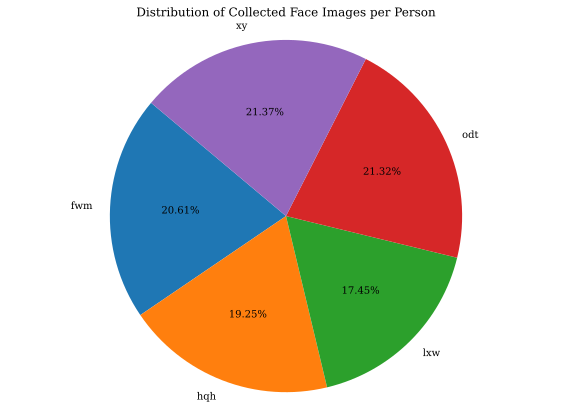

In [13]:
# 绘制饼图展示收集到的人脸数据
labels = list(face_counts.keys())
sizes = list(face_counts.values())

plt.figure(figsize=(10, 7))
plt.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=140)
plt.title('Distribution of Collected Face Images per Person')
plt.axis('equal')
plt.show()

In [19]:
# 定义数据集目录和划分后的目录
dataset_dir = 'filtered_face_dataset'
train_dir = 'train_dataset'
test_dir = 'test_dataset'

# 如果划分后的目录不存在，创建它们
if not os.path.exists(train_dir):
    os.makedirs(train_dir)
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

# 遍历每个人的文件夹
for person_name in os.listdir(dataset_dir):
    person_dir = os.path.join(dataset_dir, person_name)
    if os.path.isdir(person_dir):
        # 划分训练集和测试集
        train_files, test_files = train_test_split(
            [os.path.join(person_dir, f) for f in os.listdir(person_dir) if os.path.isfile(os.path.join(person_dir, f))],
            test_size=0.2, random_state=42
        )

        # 创建每个人的训练集和测试集目录
        person_train_dir = os.path.join(train_dir, person_name)
        person_test_dir = os.path.join(test_dir, person_name)

        if not os.path.exists(person_train_dir):
            os.makedirs(person_train_dir)
        if not os.path.exists(person_test_dir):
            os.makedirs(person_test_dir)

        # 拷贝图像文件到对应的目录
        for train_file in train_files:
            shutil.copy2(train_file, person_train_dir)
        for test_file in test_files:
            shutil.copy2(test_file, person_test_dir)